# Description
Train and retrain the weights of optical neural network encoders, using the input images or activations of hidden layers as inputs.

# Load libraries


In [1]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch QuickDraw Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--epochs', type=int, default=5000, metavar='N',
                    help='number of epochs to train (default: 100)')
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(42)
if args.cuda:
    torch.cuda.manual_seed(42)

# Dataloaders

In [3]:
class GT_QuickDraw_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.data = torch.tensor(data_import, dtype = torch.float32)
        self.targets = torch.tensor(label_import, dtype = torch.long)
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, idx):
        data = self.data[idx]
        
        if self.transform:
             data = self.transform(self.data[idx].unsqueeze(0))
            
        return data, self.targets[idx]

In [4]:
""" Prepare data loaders """

data = np.load('./Quickdraw_GT_images_April_7.npz')

train_np = data['train_data']
train_labels = data['train_labels']

train_idx = []
val_idx = []
np.random.seed(42)
for l in np.unique(train_labels):
    class_idx = (train_labels == l).nonzero()[0]
    np.random.shuffle(class_idx)
    train_idx.append(class_idx[:250])
    val_idx.append(class_idx[250:])
train_idx = np.array(train_idx).flatten()
val_idx = np.array(val_idx).flatten()

val_np = train_np[val_idx,:,:]
train_np = train_np[train_idx,:,:]
test_np = data['test_data']
test_labels = data['test_labels']

train_data_exp = np.load('./Train_Data_Quickdraw_Nonlinear_fc1act1.npz')
train_fc1 = torch.tensor(train_data_exp['train_data_before_intensifier'][train_idx,:], dtype=torch.float32)
train_act1 = torch.tensor(train_data_exp['train_data_after_intensifier'][train_idx,:], dtype=torch.float32)
train_labels = torch.tensor(train_data_exp['train_labels'][train_idx])

val_data_exp = np.load('./Train_Data_Quickdraw_Nonlinear_fc1act1.npz')
val_fc1 = torch.tensor(val_data_exp['train_data_before_intensifier'][val_idx,:], dtype=torch.float32)
val_act1 = torch.tensor(val_data_exp['train_data_after_intensifier'][val_idx,:], dtype=torch.float32)
val_labels = torch.tensor(val_data_exp['train_labels'][val_idx])

test_data_exp = np.load('./Test_Data_Quickdraw_Nonlinear_fc1act1.npz')
test_fc1 = torch.tensor(test_data_exp['test_data_before_intensifier'], dtype=torch.float32)
test_act1 = torch.tensor(test_data_exp['test_data_after_intensifier'], dtype=torch.float32)
test_labels = torch.tensor(test_data_exp['test_labels'])

train_data_exp = np.load('./Train_Data_Quickdraw_Nonlinear_fc2.npz')
train_fc2 = torch.tensor(train_data_exp['train_data_fc2'][train_idx,:], dtype=torch.float32)
train_labels = torch.tensor(train_data_exp['train_labels'])

val_data_exp = np.load('./Train_Data_Quickdraw_Nonlinear_fc2.npz')
val_fc2 = torch.tensor(train_data_exp['train_data_fc2'][val_idx,:], dtype=torch.float32)
val_labels = torch.tensor(train_data_exp['train_labels'][val_idx])

test_data_exp = np.load('./Test_Data_Quickdraw_Nonlinear_fc2.npz')
test_fc2 = torch.tensor(test_data_exp['test_data_fc2'], dtype=torch.float32)
test_labels = torch.tensor(test_data_exp['test_labels'])

transforms_input = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/190)])

transforms_input_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                         transforms.Lambda(lambda x: x.view(-1)), \
                                         transforms.Lambda(lambda x: x)])

transforms_fc1 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x)])

transforms_act1 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/10000)])

slope = torch.tensor([13567.4336, 14786.6240, 12248.9570, 12976.0381])
intercept = torch.tensor([-182514.6875, -140829.1875, -142172.0625, -175703.8750])

transforms_fc2 = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                     transforms.Lambda(lambda x: (x/slope - intercept/slope))])

#kwargs = {'num_workers': 20, 'pin_memory': True} if args.cuda else {}
kwargs = {}

""" input image loaders """
train_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_np, train_labels, transforms_input), \
    batch_size=args.batch_size, shuffle=False, **kwargs)

val_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_np, val_labels, transforms_input), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

test_loader_input = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_np, test_labels, transforms_input), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

""" fc1 output loaders """
train_loader_fc1 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_fc1, train_labels, transforms_fc1), \
    batch_size=args.batch_size, shuffle=False, **kwargs)

val_loader_fc1 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_fc1, val_labels, transforms_fc1), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

test_loader_fc1 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_fc1, test_labels, transforms_fc1), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

""" act1 loader w/. built-in samplers """
train_loader_act1 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_act1, train_labels, transforms_act1), \
    batch_size=args.batch_size, shuffle=False, **kwargs)

val_loader_act1 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_act1, val_labels, transforms_act1), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

test_loader_act1 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_act1, test_labels, transforms_act1), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

""" fc2 loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_fc2.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(val_fc2.shape[0])), \
                                              batch_size=args.test_batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_fc2.shape[0])), \
                                             batch_size=args.test_batch_size, drop_last=False)

train_loader_fc2 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_fc2, train_labels, transforms_fc2), \
    batch_sampler = train_sampler, **kwargs)

val_loader_fc2 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_fc2, val_labels, transforms_fc2), \
    batch_sampler = val_sampler, **kwargs)

test_loader_fc2 = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_fc2, test_labels, transforms_fc2), \
    batch_size = args.test_batch_size, shuffle=False, **kwargs)

train_loader_fc2_order = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_fc2, train_labels, transforms_fc2), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

val_loader_fc2_order = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_fc2, val_labels, transforms_fc2), \
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
print(next(enumerate(train_loader_fc2))[1][0].shape)
print(next(enumerate(val_loader_fc2))[1][0].shape)
print(next(enumerate(test_loader_fc2))[1][0].shape)

torch.Size([128, 4])
torch.Size([500, 4])
torch.Size([505, 4])


# NN Definitions

In [6]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out

def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [7]:
""" Definition of autoencoder structure """

coeffs = np.load('./Nonlinear_coeffs.npz')['coeffs']

class OpticalClassifier(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.nonlinear(x)
        x = self.fc2(x)
        y = self.digifc(x)
        return y

class OpticalClassifier2(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
       # x = self.fc1(x)
       # x = self.nonlinear(x)
       # x = self.fc2(x)
        y = self.digifc(x)
        return y
    
class OpticalClassifier3(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.tensor(coeffs, dtype=torch.float32), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
       # x = self.fc1(x)
       # x = self.nonlinear(x)
       # x = self.fc2(x)
        y = self.digifc(x)
        return y

In [8]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0.0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and validation functions


In [9]:
def train(epoch, model, optimizer, criterion, train_loader0, norm0=1):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data/norm0)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
#     accuracy = 100.0 * correct/len(train_loader0.dataset)
#     print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0, norm0=1):
    model.eval()
    test_loss = 0
    correct = 0
    hks = []
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data/norm0)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for i, hk in enumerate(hks):
        val_stats[f"fc{i+1}"] = wandb.Histogram(hks[i].output.cpu())      
    
    if epoch%100 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [10]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    lr_factor0 = 1E-2 * np.sqrt(128/100)
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/1.5, lr_factor0*1.5)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 1E-3, 1E-2)
    beta1 = trial.suggest_uniform("beta1", 0.999, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [1500, 2000])
    #warmup_epochs = trial.suggest_categorical("warmup_eps", [18, 24, 30])
    #model_description = f"Autoencoder_QAT_ar5wd5_lr_{learning_rate:.3f}_{lr_decay:.2f}" + f"_m_{momentum:.2f}" + f"_wp_{warmup_epochs}"+ f"_v_{trial.number}"
    model_description = f"graft_AdamW_lr_{learning_rate:.6f}_bs_{batch_size}_lrf_{lr_factor:.4f}_b1_{beta1:.4f}_b2_{beta2:.4f}_swalr_{swa_lr:.3f}_{swa_start}" + f"_v_{trial.number}"
    
    # Instantiate a model for finetuning
    model = OpticalClassifier3(36, 4)
    model_ckpt = torch.load("./Gen3_fc2_finetune.pt", map_location=torch.device('cpu')) 
    model_state_dict = model_ckpt["model_state_dict"]
    model.load_state_dict(model_state_dict)
    model.fc1.W_Opt.requires_grad = False
    model.fc2.W_Opt.requires_grad = False
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+1000)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 30:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [11]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [12]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [0,]
rseeds = [1514,6,21,93258,2135]

NAS_project_name = "Quickdraw_nonlinear_digifc_retrain"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader_fc2, val_loader_fc2)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

KeyboardInterrupt: 

In [27]:
ray.shutdown()

# Check inputs

In [13]:
%matplotlib notebook

In [14]:
import matplotlib.pyplot as plt

idx = 60
fig, axes = plt.subplots(1,1)
plt.imshow(next(enumerate(train_loader_input))[1][0][0,:].view(40,-1))

<IPython.core.display.Javascript object>

# Check fc1

In [16]:
model0 = OpticalClassifier(36,4)
# model_ckpt = torch.load("./v120_ep626.pt", map_location=torch.device('cpu')) 
model_ckpt = torch.load("./Gen2_retrain_fc1act1.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model0.load_state_dict(model_state_dict)

hk_fc1 = Hook(model0.fc1)
hk_act1 = Hook(model0.nonlinear)
hk_fc2 = Hook(model0.fc2)
model0(next(enumerate(train_loader_input))[1][0])
hk_fc1.output.cpu().shape

torch.Size([128, 36])

<IPython.core.display.Javascript object>


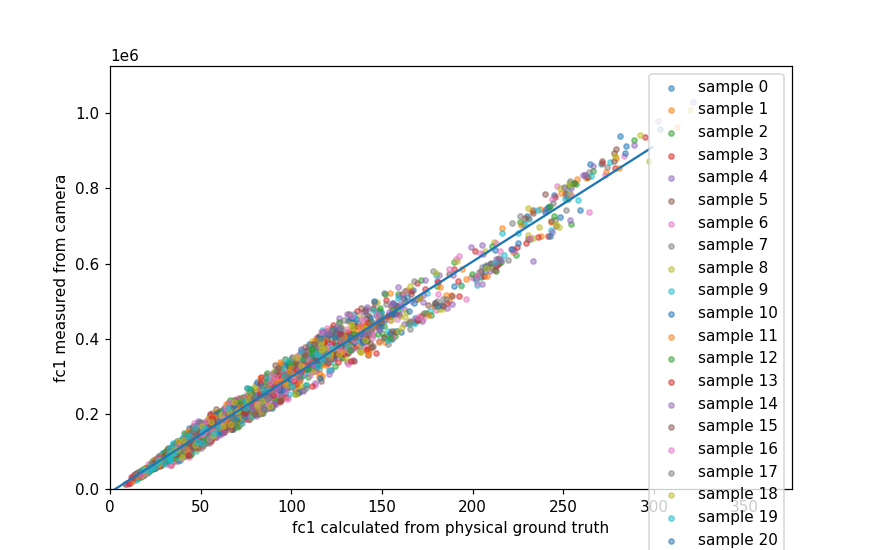

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


[[3066.8538]]
[-7456.875]


In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fc1_calc_batch = hk_fc1.output.cpu()[range(100),:].detach().numpy()
#fc1_meas_batch = train_fc1[:100,:].detach().numpy()
fc1_meas_batch = next(enumerate(train_loader_fc1))[1][0][:100,:].detach().numpy()
reg = LinearRegression().fit(fc1_calc_batch.reshape(-1,1), fc1_meas_batch.reshape(-1,1))
for idx in range(100):
    fc1_calc = fc1_calc_batch[idx,:]
    fc1_meas = fc1_meas_batch[idx,:]
    ax.scatter(fc1_calc, fc1_meas, alpha=0.5, linestyle="solid", s=12, label=f"sample {idx}")

x0 = np.arange(0,300,1).reshape(-1,1)
T2_inv = lambda x: x * reg.coef_ + reg.intercept_
ax.plot(x0, T2_inv(x0))
# axes labels and title
ax.set_xlabel("fc1 calculated from physical ground truth", fontname="Arial")
ax.set_ylabel("fc1 measured from camera", fontname="Arial")
ax.set_xlim(0,)
ax.set_ylim(0,)
#plt.title("title")

#auto legend setting and figure config
ax.legend()
plt.tight_layout()

plt.show()
print(reg.coef_)
print(reg.intercept_)

# Check Nonlinearity

<IPython.core.display.Javascript object>


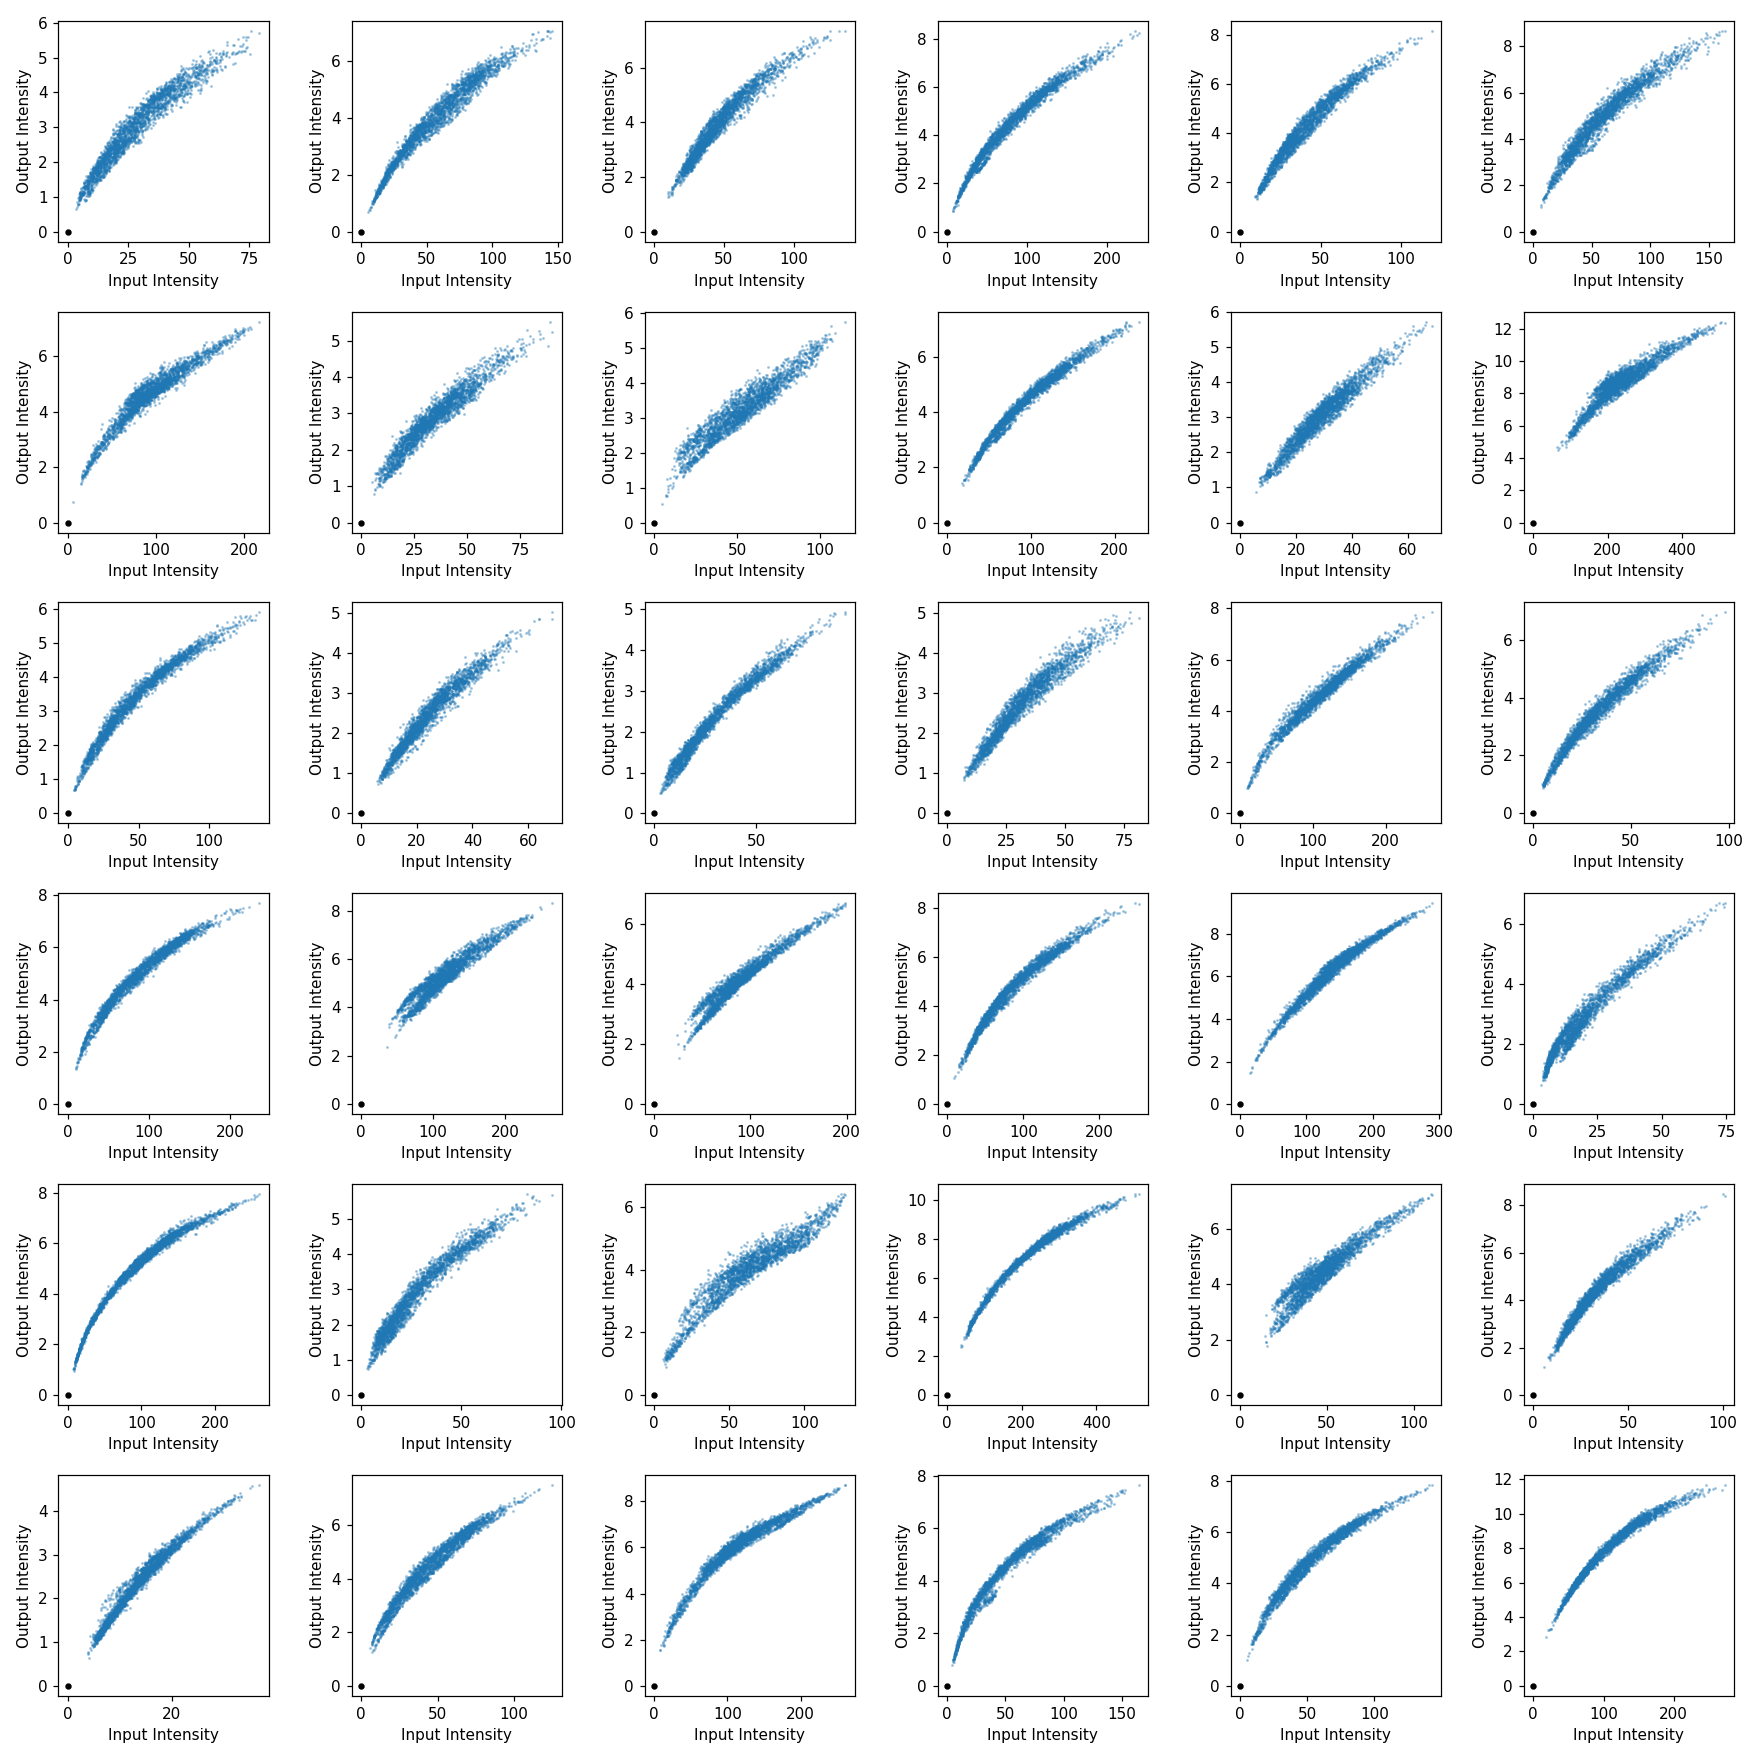

In [19]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

fig, axes = plt.subplots(6, 6, figsize = (16, 16))
T1_inv = lambda x: (x+7453.8438)/3066.7986
T2_inv = lambda x: x/9000
for k in range(36):
    i = k//6
    j = k%6
    ax = axes[i,j]
    ax.scatter(0, 0, s=10, c='k')
    x = T1_inv(train_fc1[:,k]).detach().numpy()
    y = T2_inv(train_act1[:,k]).detach().numpy()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    ax.scatter(x, y, s=1, alpha=0.3)
    ax.set_xlabel('Input Intensity')
    ax.set_ylabel('Output Intensity')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

# Check fc2

<IPython.core.display.Javascript object>


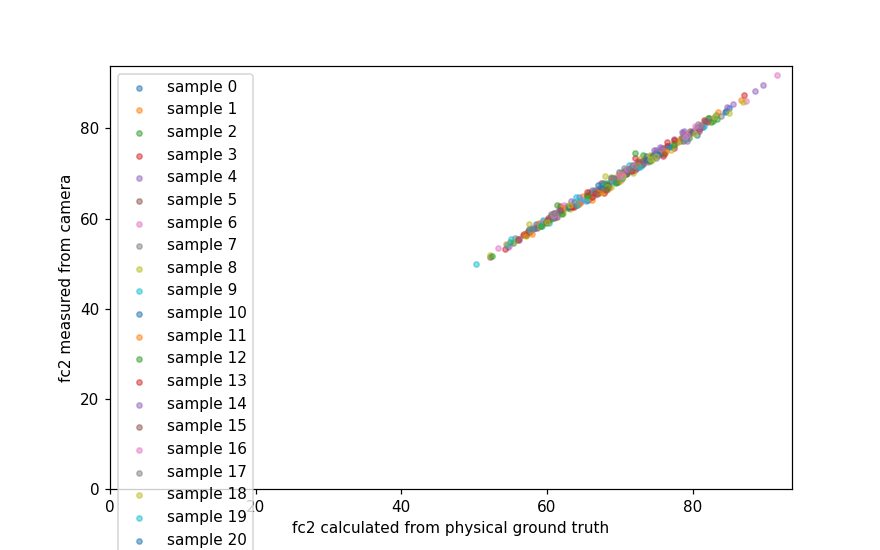

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


[[0.98872757]]
[0.2492218]


In [20]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fc2_calc_batch = hk_fc2.output.cpu()[range(100),:].detach().numpy()
fc2_meas_batch = next(enumerate(train_loader_fc2_order))[1][0][:100,:].detach().numpy()
reg = LinearRegression().fit(fc2_calc_batch.reshape(-1,1), fc2_meas_batch.reshape(-1,1))
for idx in range(100):
    fc2_calc = fc2_calc_batch[idx,:]
    fc2_meas = fc2_meas_batch[idx,:]
    ax.scatter(fc2_calc, fc2_meas, alpha=0.5, linestyle="solid", s=12, label=f"sample {idx}")

# x0 = np.arange(0,10,1).reshape(-1,1)
# T2_inv = lambda x: x * reg.coef_ + reg.intercept_
# ax.plot(x0, T2_inv(x0))
# axes labels and title
ax.set_xlabel("fc2 calculated from physical ground truth", fontname="Arial")
ax.set_ylabel("fc2 measured from camera", fontname="Arial")
ax.set_xlim(0,)
ax.set_ylim(0,)
#plt.title("title")

#auto legend setting and figure config
ax.legend()
plt.tight_layout()

plt.show()
print(reg.coef_)
print(reg.intercept_)

<IPython.core.display.Javascript object>


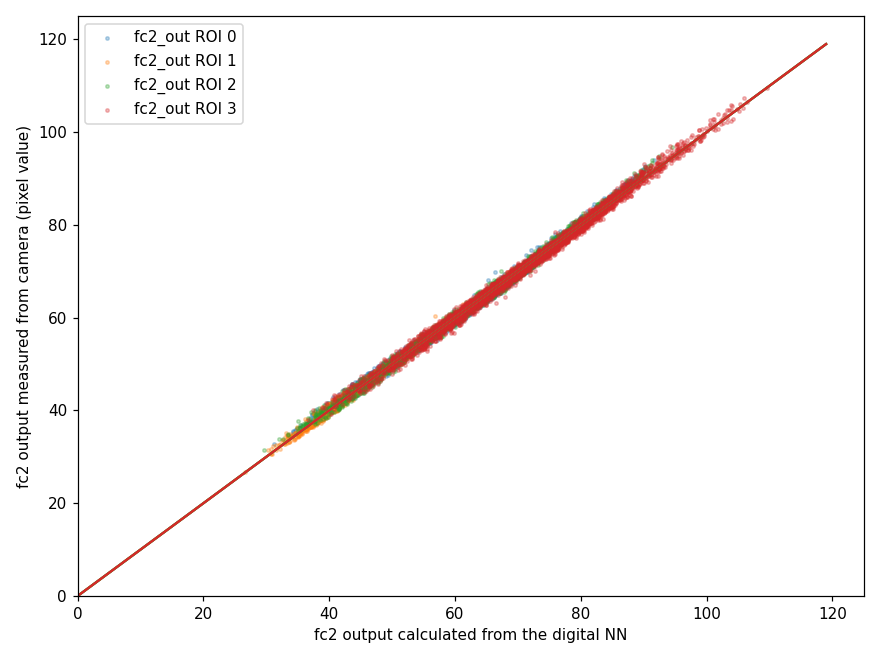

tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([7.6294e-06, 1.1444e-05, 0.0000e+00, 0.0000e+00])


In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

def T2(x, a, b, c):
    return a*np.exp(b*x) + c

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

fc2_calc_batch = hk_fc2.output.cpu()[range(3000),:].detach().numpy()
#fc2_meas_batch = train_fc2[:100,:].detach().numpy()
fc2_meas_batch = next(enumerate(train_loader_fc2))[1][0][:3000,:].detach().numpy()
x0 = np.arange(0,120,1).reshape(-1,1)
recali_coeffs = []
recali_bias = []

for d in range(4):
    fc2_calc = fc2_calc_batch[:,d]
    fc2_meas = fc2_meas_batch[:,d]
    ax.scatter(fc2_calc, fc2_meas, alpha=0.3, s=5, label=f"fc2_out ROI {d}")
#     popt, _ = curve_fit(T2, fc2_calc, fc2_meas, p0=p0s[d,:], maxfev=5000)
#     ax.plot(x0, T2(x0, *popt))
#     fc2_recali_coeffs[d,:] = popt
    reg = LinearRegression().fit(fc2_calc_batch[:,d].reshape(-1,1), fc2_meas_batch[:,d].reshape(-1,1))
    recali_coeffs.append(reg.coef_.item())
    recali_bias.append(reg.intercept_.item())
    T2_inv = lambda x: x * reg.coef_ + reg.intercept_
    ax.plot(x0, T2_inv(x0))
# for idx in range(100):
#     fc2_calc = fc2_calc_batch[idx,:]
#     fc2_meas = fc2_meas_batch[idx,:]
#     ax.scatter(fc2_calc, fc2_meas, alpha=0.5, linestyle="solid", s=12, label=f"sample {idx}")


#T2_inv = lambda x: x * reg.coef_ + reg.intercept_
#ax.plot(x0, T2_inv(x0))
# axes labels and title
ax.set_xlabel("fc2 output calculated from the digital NN", fontname="Arial")
ax.set_ylabel("fc2 output measured from camera (pixel value)", fontname="Arial")
ax.set_xlim(0,)
ax.set_ylim(0,)
#plt.title("title")

#auto legend setting and figure config
ax.legend()
plt.tight_layout()

plt.show()
recali_coeffs = torch.tensor(recali_coeffs)
recali_bias = torch.tensor(recali_bias)

print(recali_coeffs)
print(recali_bias)
#plt.savefig("fc2_out_linearly_corrected.png", dpi=300, format="png")


# Test models

In [21]:
model = OpticalClassifier3(36, 4)
model_ckpt = torch.load("./Gen4_retrain_digifc.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [22]:
import matplotlib.pyplot as plt

model.cpu()
# hkfc3 = Hook(model.encoder_nn[4])
B = next(enumerate(test_loader_fc2))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(399) tensor(79.0099)


<IPython.core.display.Javascript object>


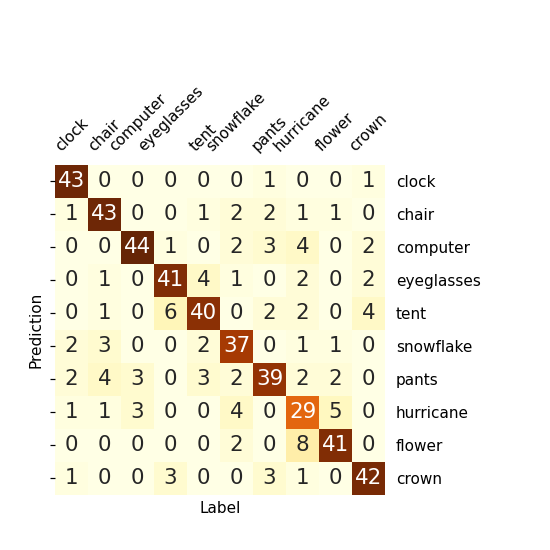

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

idx2class = {0:'clock', 1:'chair', 2:'computer', 3:'eyeglasses', 4:'tent', \
             5:'snowflake', 6:'pants', 7:'hurricane', 8:'flower', 9:'crown'}
class2idx = {v: k for k, v in idx2class.items()}

batch = next(enumerate(test_loader_fc2))[1]
output = model(batch[0])
pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
labels = batch[1]

conMat = {}
for i in range(len(labels.unique())):
    subdf_idx = (labels == i)     
    conMat[f"label {i}"] = [(pred[subdf_idx] == j).sum().item() for j in range(len(labels.unique()))]
df = pandas.DataFrame(conMat)

df = df.rename(columns=dict(zip(df.columns,  list(idx2class.values()))), \
               index=dict(zip(df.index,  list(idx2class.values()))))
df.index.name = 'Prediction'
df.columns.name = 'Label'
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.set_position([0.1,0.1,0.6,0.6])
sns.set(font_scale=1.4)#for label size
#df[df==0] = np.nan
sns.heatmap(df, cmap="YlOrBr", annot=True, annot_kws={"size": 14}, cbar=False)# font size
ax.tick_params(axis='x', rotation=45, labelbottom=False, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='y', rotation=0, labelleft=False, labelright=True)
ax.yaxis.set_label_position("left")
# ax.set_ylabel('Prediction', rotation=270)
# plt.tick_params(axis='both', which='major', labelsize=10, , )
# plt.savefig(f"./Figures/quickdraw_nonlinear_confusion_matrix.svg", dpi=300, format="svg")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
